In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
# Workaround for a bug in Pims.
from slicerator import Slicerator

@Slicerator.from_class
class Lazy_Gray:
    def __init__(self, frame_arr):
        self.frame_arr = frame_arr

    def __getitem__(self, i):
        # this method will be wrapped by Slicerator, so that it accepts slices,
        # lists of integers, or boolean masks. Code below will only be executed
        # when an integer is used.

        # load thing number i
        item = self.frame_arr[i]
        return item[:, :, 0]

    def __len__(self):
        return len(self.frame_arr)

In [8]:
# Now, onto loading. Pims lazy loads images, which is good. It knows what we have, but won't do anything
# to load it until we access it

frames = pims.Video('data1/PB030036.MOV')

# Brute force convert to grayscale, as pims.Video doesn't allow this.
frames = Lazy_Gray(frames)

AVError: [Errno 2] No such file or directory: 'data0/PB030036.MOV'

# Calibrating TrackPy 

---

Calibrating TrackPy is crucial to getting any kind of sensible result. If you are new to TrackPy, please read the following procedure carefully-it will make the difference between 50% and <1% experimental error.

### Initial Setup
Before we begin, we need to set three variables for TrackPy to analyze our sequence optimally:

1. Set userInvert to True if your image sequence has black particles on a white background, and False for white particles on a black background.
2. Set imageHasDrift to True if you are analyzing a recording of real particles or a generated random walk with specified drift, or False if you are analyzing a generated random walk with no drift or you are absolutely sure that your recording of real particles has no drift. 
3. Set numFramesToAnalyze to any number above zero that is less than or equal to the number of frames you have to analyze. You can use this to analyze a subset of your availiable data if you so desire by setting it to a value less than the actual number of frames you have available.

### Determine minMass and maxMass
Now we can really start. Use the code block below to begin single frame analysis for testing. It will generate an image with particles circled. We can use this image to filter out what is and isn't a particle, since TrackPy identifies particles by RGB mass - the closer a particle is to absolute white against a black background, or absolute black against a white background, the heavier it is. Set the minmass to a value that eliminates spurious or faint particles. You can use the graph of the RGB masses to determine what is a reasonable mass, and what mass is too high or small. Set userMinMass and userMaxMass with this information.

### Determine particle diameter 
Next, use the graph of the subpixel bias to calibrate userDiameterToLook. Keep adjusting this value until you get an even distribution of values. The purpose of this procedure is to demonstrate subpixel accuracy by checking that the x- and y- components are evenly distributed. 

### Determine userWalkRadius
Finally, estimate the userWalkRadius. This variable describes the maximum distance TrackPy expects a particle to travel. Must be odd, err on larger values. Values that are too small will create a parabolic graph, because TrackPy will have cascading displacement recognition issues.

In [11]:
#Define user vars to calibrate the program
userMinMass = 700
userMaxMass = 8000
numFramesToAnalyze = len(frames)
userDiameterToLook = 15
userWalkRadius = 11 # Change This
userFrameMemory = 0
userInvert = False
imageHasDrift = False
print("There are ", len(frames), " frames")

There are  4665  frames


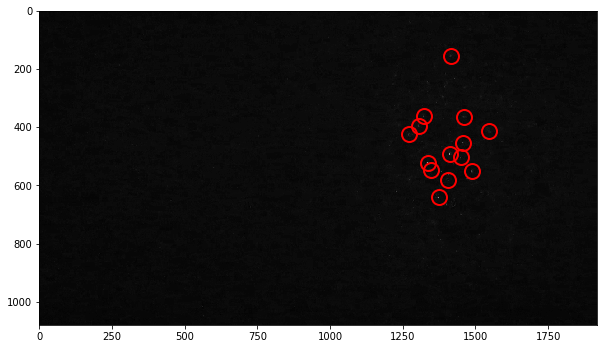

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fca203a1b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fca1a0b1cc0>]], dtype=object)

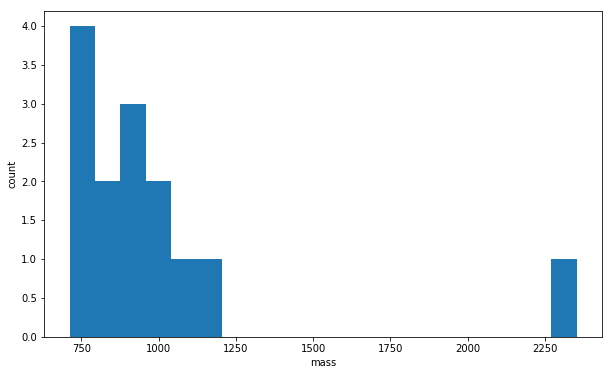

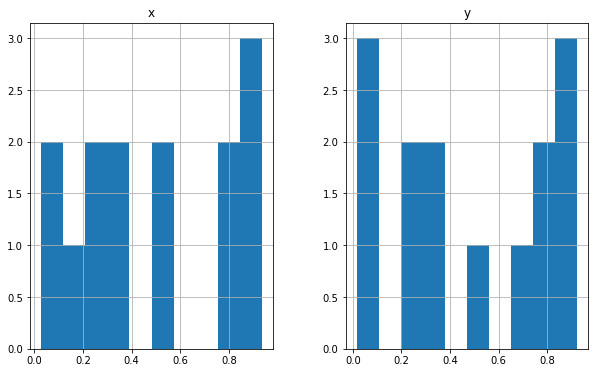

In [12]:
# Single frame analysis for testing
f = tp.locate(frames[14], userDiameterToLook, invert=userInvert, minmass=userMinMass)

plt.figure()
fig, ax = plt.subplots()
tp.annotate(f, frames[14])
plt.show()

#Graph all of the RGB masses we see in this image
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
ax.set(xlabel='mass', ylabel='count')

#Now, graph the subpixel bias to determine if we have 
plt.figure()
tp.subpx_bias(f)

In [ ]:
# Multiframe analysis
f = tp.batch(frames[:numFramesToAnalyze], userDiameterToLook,
             minmass=userMinMass, invert=userInvert, characterize=False)

# Allow a particle to go missing for up to userFrameMemory frames, and have up to userWalkRadius movement
# (in px) per frame
t = tp.link_df(f, userWalkRadius, memory=userFrameMemory)
t1 = tp.filter_stubs(t, numFramesToAnalyze)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Frame 1681: 6 features


In [ ]:
plt.figure()
tp.plot_traj(t);

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.ion()

for i in range(450, 850):
    ax.clear()
    tp.annotate(f[f['frame'] == i], frames[i])
    fig.canvas.draw()
print("Reached EOF")

In [9]:
t1

,x,y,mass,frame,particle
frame,,,,,
0,844.594481,60.800281,1411.187744,0,0.0
1,845.056147,61.465634,1317.724041,1,0.0
2,844.774476,62.406722,1286.190513,2,0.0
3,844.540460,62.214286,1234.711785,3,0.0
4,844.131899,61.692236,1394.022125,4,0.0
5,845.518830,62.744059,1714.288984,5,0.0
6,845.464104,63.586112,1579.163228,6,0.0
7,845.280260,63.496344,1489.795531,7,0.0
8,845.042101,63.626704,1490.707304,8,0.0


<IPython.core.display.Javascript object>


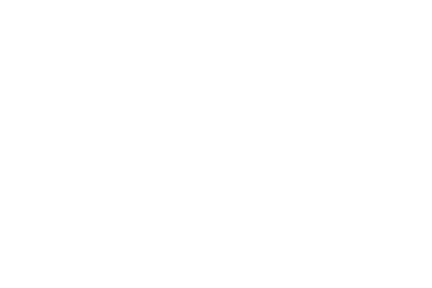

<IPython.core.display.Javascript object>


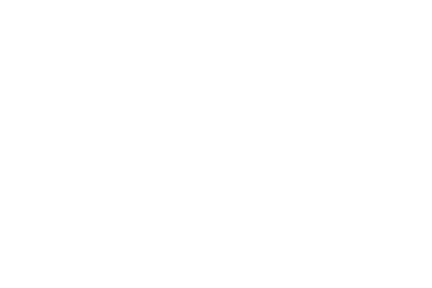

In [10]:
for particlenum in t1['particle'].unique():
    plt.plot(t1[t1['particle'] == particlenum])
plt.show()